In [1]:
import os
os.chdir("/home/yasser/classes/DL26/final_Project")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils.data_fetcher import create_loaders
from src.utils.SRESNET import SRResNet
from src.utils.helper_functions import train_sr, val_sr, plot_sr_progress


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

device : cuda


In [3]:
from src.utils.config import CONFIG
# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]

In [4]:
train_loader, val_loader, test_loader = create_loaders("./data/preprocessed",batch_size=36)


📦 DATA LOADED:
  Train: 64800 samples
  Val:   8100 samples
  Test:  8100 samples


In [5]:
model = SRResNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


 Training from scratch

Epoch 1/10


Train loss: 0.003535 | Train PSNR: 24.55 dB
Val   loss: 0.002933 | Val   PSNR: 25.97 dB
→ Current LR: 0.00010000

Epoch 2/10


Train loss: 0.003375 | Train PSNR: 24.76 dB
Val   loss: 0.002559 | Val   PSNR: 26.68 dB
→ Current LR: 0.00010000

Epoch 3/10


Train loss: 0.003202 | Train PSNR: 24.98 dB
Val   loss: 0.002515 | Val   PSNR: 26.72 dB
→ Current LR: 0.00010000

Epoch 4/10


Train loss: 0.003062 | Train PSNR: 25.18 dB
Val   loss: 0.002428 | Val   PSNR: 26.90 dB
→ Current LR: 0.00010000

Epoch 5/10


Train loss: 0.002961 | Train PSNR: 25.33 dB
Val   loss: 0.002395 | Val   PSNR: 26.94 dB
→ Current LR: 0.00010000

Epoch 6/10


Train loss: 0.002893 | Train PSNR: 25.43 dB
Val   loss: 0.002314 | Val   PSNR: 27.11 dB
→ Current LR: 0.00010000

Epoch 7/10


Train loss: 0.002834 | Train PSNR: 25.52 dB
Val   loss: 0.002287 | Val   PSNR: 27.17 dB
→ Current LR: 0.00010000

Epoch 8/10


Train loss: 0.002788 | Train PSNR: 25.59 dB
Val   loss: 0.002202 | Val   PSNR: 27.35 dB
→ Current LR: 0.00010000

Epoch 9/10


Train loss: 0.002748 | Train PSNR: 25.65 dB
Val   loss: 0.002170 | Val   PSNR: 27.42 dB
→ Current LR: 0.00010000

Epoch 10/10


Train loss: 0.002713 | Train PSNR: 25.71 dB
Val   loss: 0.002127 | Val   PSNR: 27.51 dB
→ Current LR: 0.00010000


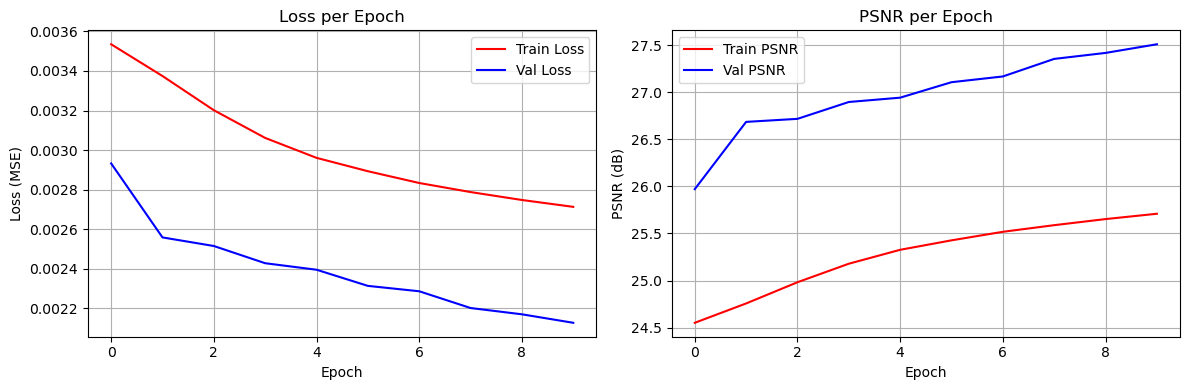

In [7]:
train_losses, val_losses = [], []
train_psnrs,  val_psnrs  = [], []

best_psnr = 0.0

num_epochs = 10
print(" Training from scratch")


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # TRAIN 
    train_loss, train_psnr, _ = train_sr(
        model=model,
        train_loader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device,
        scale_factor=4,
        model_requires_upscale=False,   
        scheduler=scheduler
    )

    # VALIDATION 
    val_loss, val_psnr = val_sr(
        model=model,
        val_loader=val_loader,
        loss_fn=criterion,
        device=device,
        scale_factor=4,
        model_requires_upscale=False
    )


    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_psnrs.append(train_psnr)
    val_psnrs.append(val_psnr)

    print(f"Train loss: {train_loss:.6f} | Train PSNR: {train_psnr:.2f} dB")
    print(f"Val   loss: {val_loss:.6f} | Val   PSNR: {val_psnr:.2f} dB")
    print(f"→ Current LR: {optimizer.param_groups[0]['lr']:.8f}")

# PLOT
plot_sr_progress(train_losses, val_losses, train_psnrs, val_psnrs)


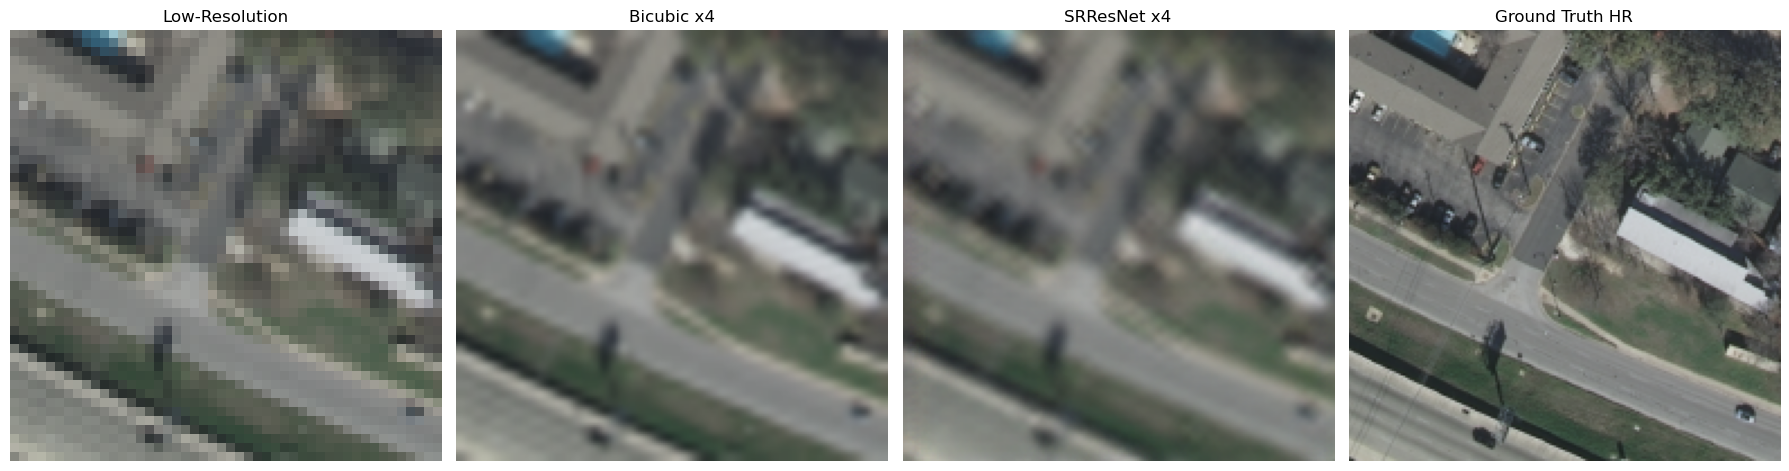

Saved output images.


(<PIL.Image.Image image mode=RGB size=48x48>,
 <PIL.Image.Image image mode=RGB size=192x192>,
 <PIL.Image.Image image mode=RGB size=192x192>,
 <PIL.Image.Image image mode=RGB size=192x192>)

In [17]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

model.eval()

# ----------------------------------------------------
# TRANSFORMS
# ----------------------------------------------------
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# ----------------------------------------------------
# LOAD IMAGE
# ----------------------------------------------------
def load_image(path):
    return Image.open(path).convert("RGB")

# ----------------------------------------------------
# BICUBIC UPSCALE
# ----------------------------------------------------
def bicubic_upscale(lr_img, scale=4):
    w, h = lr_img.size
    return lr_img.resize((w * scale, h * scale), Image.BICUBIC)

# ----------------------------------------------------
# SUPER RESOLUTION (SRResNet)
# ----------------------------------------------------
def run_srresnet(model, lr_img):
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_tensor = model(lr_tensor).clamp(0, 1)

    return to_pil(sr_tensor.squeeze(0).cpu())

# ----------------------------------------------------
# COMPARISON PIPELINE
# ----------------------------------------------------
def compare_images(lr_path, hr_path, scale=4):
    # Load LR and HR
    lr_img = load_image(lr_path)
    hr_img = load_image(hr_path)

    # Bicubic upscaled
    bic_img = bicubic_upscale(lr_img, scale)

    # SRResNet output
    sr_img = run_srresnet(model, lr_img)

    # Show results
    plt.figure(figsize=(18, 8))

    titles = ["Low-Resolution", "Bicubic x4", "SRResNet x4", "Ground Truth HR"]
    images = [lr_img, bic_img, sr_img, hr_img]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # save outputs
    lr_img.save("output_lr.png")
    bic_img.save("output_bicubic.png")
    sr_img.save("output_sr.png")
    print("Saved output images.")

    return lr_img, bic_img, sr_img, hr_img

# ----------------------------------------------------
# RUN TEST
# ----------------------------------------------------
compare_images(
    lr_path="./data/preprocessed/test/LR/austin1_r01_c03.png",   # <--- your LR image
    hr_path="./data/preprocessed/test/HR/austin1_r01_c03.png"    # <--- matching HR image
)